# 2. Monte Carlo as Probability & Integration

**Goal.** Understand Monte Carlo as an *estimator of expectations* and integrals.  
By the end of this notebook, you should be able to:
- Explain MC as a probability/integration tool.  
- Estimate π via hit–miss sampling.  
- Quantify uncertainty (standard error, confidence interval).  
- Visualize convergence with sample size.

**Roadmap.**
- 2.1 Monte Carlo as Expectation  
- 2.2 Estimating π (Hit–Miss)  
- 2.3 Convergence & Confidence Intervals  
- 2.4 Extending to General Integrals


## 2.1 Monte Carlo as Expectation

**The formula**

If $X \sim p(x)$ is a random variable, then for any function $g$:

$$
\mathbb{E}[g(X)] \;=\; \int g(x)\,p(x)\,dx.
$$

If we draw $N$ random samples $X_1, \dots, X_N$, the Monte Carlo (MC) estimator is:

$$
\hat{\mu}_N \;=\; \frac{1}{N}\sum_{i=1}^N g(X_i).
$$

**Plain explanation**

- The expectation $\mathbb{E}[g(X)]$ is the "true average" of $g(X)$ if we could observe infinitely many samples.  
- Since we can’t, we approximate it by taking a **finite average** of $N$ random draws.  
- This is exactly what Monte Carlo does: replace a hard integral with an average over random samples.  

**Error behavior**

The estimate has noise, measured by the **Standard Error (SE):**

$$
\mathrm{SE}(\hat{\mu}_N) \approx \frac{\hat{\sigma}}{\sqrt{N}},
$$

where $\hat{\sigma}^2$ is the sample variance of the $g(X_i)$.

- In words: as $N$ grows, the error shrinks like $1/\sqrt{N}$.  
- Example: if we quadruple the sample size, the error halves.


## 2.2 Estimating π via Hit–Miss

**The formula**

- Throw random points \((x,y)\) uniformly in the unit square \([0,1]^2\).  
- Define an indicator variable:
\[
I_i = \mathbf{1}\{x_i^2 + y_i^2 \le 1\}.
\]
- The average of these indicators estimates the area of the quarter circle:
\[
\mathbb{E}[I] = \pi/4.
\]
- Therefore, our estimator of π is:
\[
\widehat{\pi} = 4 \cdot \frac{1}{N}\sum_{i=1}^N I_i.
\]

**Plain explanation**

- We are throwing darts randomly into a square of size 1×1.  
- Some darts land inside the quarter circle (radius 1 in the corner).  
- The fraction of darts inside the circle ≈ area of circle / area of square = π/4.  
- Multiply this fraction by 4, and we get an estimate of π.  

**Uncertainty**

The standard error comes from the variability of the hits/misses:
\[
\mathrm{SE} = 4 \sqrt{\frac{\hat{p}(1-\hat{p})}{N}}, \quad 
\hat{p} = \frac{1}{N}\sum I_i.
\]

In words:  
- \(\hat{p}\) is just the proportion of points inside the circle.  
- The SE shrinks as we add more samples.  
- A 95% confidence interval is the estimate ± 2·SE.


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
DEFAULT_SEED = 42
rng = np.random.default_rng(DEFAULT_SEED)

def f4(x: float) -> str:
    """Pretty formatting for floats"""
    return f"{x:.4f}"


In [2]:
from typing import Tuple, Optional

def estimate_pi_hitmiss(
    n_samples: int,
    rng: np.random.Generator,
    return_points: bool = False
) -> Tuple[float, float, Tuple[float, float], Optional[tuple]]:
    """
    Estimate π using hit–miss Monte Carlo in the unit square.

    Method
    ------
    - Draw (x_i, y_i) ~ Uniform([0,1]^2), i=1..N.
    - Indicator I_i = 1 if x_i^2 + y_i^2 <= 1, else 0.
    - p_hat = (1/N) * sum I_i  ≈  area of quarter circle = π/4.
    - pi_hat = 4 * p_hat.

    Uncertainty (approx. 95% CI using normal approximation):
    - SE = 4 * sqrt(p_hat*(1-p_hat)/N)
    - CI = [pi_hat - 1.96*SE, pi_hat + 1.96*SE]

    Parameters
    ----------
    n_samples : int
        Number of random points to draw.
    rng : np.random.Generator
        Numpy random generator (for reproducibility).
    return_points : bool
        If True, also return (x, y, inside_mask) for visualization.

    Returns
    -------
    pi_hat : float
        Monte Carlo estimate of π.
    se : float
        Standard error of the estimate.
    ci : (float, float)
        95% confidence interval (lower, upper).
    pts : tuple or None
        If return_points=True, returns (x, y, inside_mask), else None.
    """
    # Draw points in [0,1]^2
    x = rng.random(n_samples)
    y = rng.random(n_samples)

    # Inside quarter circle?
    inside = (x*x + y*y) <= 1.0

    # Proportion inside (area ≈ π/4)
    p_hat = inside.mean()
    pi_hat = 4.0 * p_hat

    # Binomial-based SE for p_hat, propagated to π
    se = 4.0 * math.sqrt(max(p_hat * (1.0 - p_hat), 0.0) / n_samples)

    # 95% normal CI
    ci_low = pi_hat - 1.96 * se
    ci_high = pi_hat + 1.96 * se

    pts = (x, y, inside) if return_points else None
    return pi_hat, se, (ci_low, ci_high), pts


In [3]:
N = 20_000  # try 2_000, 20_000, 200_000 to feel the √N effect
pi_hat, se, (ci_low, ci_high), _ = estimate_pi_hitmiss(N, rng, return_points=False)

print(f"N = {N}")
print(f"π estimate     : {f4(pi_hat)}")
print(f"Std. error     : {f4(se)}")
print(f"95% CI         : [{f4(ci_low)}, {f4(ci_high)}]")
print(f"True π         : {f4(math.pi)}  (inside CI? {'yes' if (ci_low<=math.pi<=ci_high) else 'no'})")


N = 20000
π estimate     : 3.1430
Std. error     : 0.0116
95% CI         : [3.1203, 3.1657]
True π         : 3.1416  (inside CI? yes)


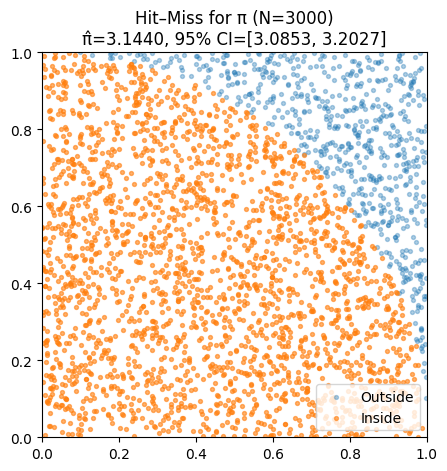

In [4]:
# Smaller N for a readable scatter
N_scatter = 3_000
pi_hat_s, se_s, (ci_l_s, ci_h_s), pts = estimate_pi_hitmiss(N_scatter, rng, return_points=True)
x, y, inside = pts

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x[~inside], y[~inside], s=8, alpha=0.35, label="Outside")
ax.scatter(x[inside], y[inside], s=8, alpha=0.6, label="Inside")
ax.set_aspect('equal', 'box')
ax.set_xlim(0, 1); ax.set_ylim(0, 1)
ax.set_title(f"Hit–Miss for π (N={N_scatter})\nπ̂={f4(pi_hat_s)}, 95% CI=[{f4(ci_l_s)}, {f4(ci_h_s)}]")
ax.legend(loc="lower right")
plt.show()


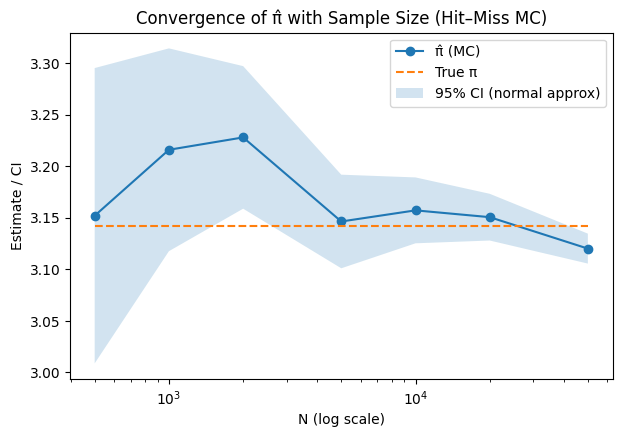

In [5]:
Ns = [500, 1_000, 2_000, 5_000, 10_000, 20_000, 50_000]
estimates, ses, ci_lows, ci_highs = [], [], [], []

# Fresh RNG for a clean sweep (optional)
rng_conv = np.random.default_rng(123)

for n in Ns:
    pi_hat_i, se_i, (ci_l_i, ci_h_i), _ = estimate_pi_hitmiss(n, rng_conv, return_points=False)
    estimates.append(pi_hat_i); ses.append(se_i)
    ci_lows.append(ci_l_i); ci_highs.append(ci_h_i)

fig, ax = plt.subplots(figsize=(7, 4.5))
ax.plot(Ns, estimates, marker='o', label="π̂ (MC)")
ax.plot(Ns, [math.pi]*len(Ns), linestyle='--', label="True π")
ax.fill_between(Ns, ci_lows, ci_highs, alpha=0.2, label="95% CI (normal approx)")
ax.set_xscale('log')
ax.set_xlabel("N (log scale)")
ax.set_ylabel("Estimate / CI")
ax.set_title("Convergence of π̂ with Sample Size (Hit–Miss MC)")
ax.legend()
plt.show()
